## Histone deacetylase 1 - part 3 (rule aggregation)

### Import libraries

In [1]:
import pandas as pd

### Read in the datasets

In [2]:
df = pd.read_csv('hdac1_inhibitors_stripped.csv')
df_pairs = pd.read_csv('hdac1_inhibitors_pairs.csv')

### Determine which measurements can be included in delta property calculation

In [3]:
df['pchembl_exact'] = df.apply(lambda x: x.pchembl_value if x.standard_relation == "=" and x.pchembl_value else None, axis=1)

### Combine twice with confirmed molecular pairs

In [4]:
df_merge = df_pairs.merge(df, left_on='smiles1', right_on='stripped_smiles')
df_merge = df_merge.merge(df, left_on=['smiles2', 'assay_chembl_id'], right_on=['stripped_smiles', 'assay_chembl_id'])
df_merge['pchembl_exact_delta'] = df_merge['pchembl_exact_y'] - df_merge['pchembl_exact_x'] 
df_merge.sample(3).transpose()

,1133,1651,956
smiles1,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C#...,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C#...
smiles2,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1
percentmcs,0.909091,0.75,0.848485
radius,4.0,3.0,2.0
valid,True,True,True
...,...,...,...
ligand_efficiency.bei_y,16.98,NaN,NaN
ligand_efficiency.le_y,0.33,NaN,NaN
stripped_smiles_y,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1
pchembl_exact_y,7.88,NaN,NaN


### Filter mcs > 90%

In [5]:
df_agg = df_merge[(df_merge.percentmcs > 0.9) & pd.notna(df_merge.pchembl_exact_delta)]

### Aggregate data by the two fragments

In [6]:
indexcols = ['fragment1', 'fragment2', 'radius', 'assay_chembl_id']
df_agg_data = pd.pivot_table(df_agg, values='pchembl_exact_delta', index=indexcols, aggfunc=['count','mean'])
df_agg_data.columns = ['_'.join(col).strip() for col in df_agg_data.columns.values]

### Retain single SMIRKS per transformation (effectively at random)

In [7]:
df_agg_smirks = pd.pivot_table(df_agg, values='smirks', index=indexcols, aggfunc='first')
df_agg = df_agg_data.join(df_agg_smirks).reset_index()

### Write to file

In [8]:
df_agg.to_csv('hdac1_inhibitors_transformations.csv', index=False)

### ...and finally plot (figure 3 from wizepairz paper)

In [9]:
df_plot = df_agg[df_agg.radius == 3]
df_plot = pd.pivot_table(df_plot, values='mean_pchembl_exact_delta', index=['fragment1', 'fragment2', 'radius'], columns='assay_chembl_id', aggfunc='first')
df_plot

assay_chembl_id                                                           CHEMBL927948  \
fragment1                        fragment2                        radius                 
1e5e8361c8f05f9f512e901d22506931 66c735f6aa9c5b5cc24a7258604abfe3 3.0         0.293333   
                                 709d9861baef05140bf108058786fabf 3.0         0.110000   
                                 f023e31e01c29c216d13ecf4ae323f3b 3.0        -0.305000   
1fd8ece99712a9432eb8759959e992c6 a545b6dcb46a2e453d6a86e729aa3e08 3.0         0.016667   
66c735f6aa9c5b5cc24a7258604abfe3 1e5e8361c8f05f9f512e901d22506931 3.0        -0.293333   
                                 709d9861baef05140bf108058786fabf 3.0        -0.160000   
                                 f023e31e01c29c216d13ecf4ae323f3b 3.0        -0.605000   
709d9861baef05140bf108058786fabf 1e5e8361c8f05f9f512e901d22506931 3.0        -0.110000   
                                 66c735f6aa9c5b5cc24a7258604abfe3 3.0         0.160000   
                                 f023e31e01c29c216d13ecf4ae323f3b 3.0        -0.400000   
a545b6dcb46a2e453d6a86e729aa3e08 1fd8ece99712a9432eb8759959e992c6 3.0        -0.016667   
f023e31e01c29c216d13ecf4ae323f3b 1e5e8361c8f05f9f512e901d22506931 3.0         0.305000   
                                 66c735f6aa9c5b5cc24a7258604abfe3 3.0         0.605000   
                                 709d9861baef05140bf108058786fabf 3.0         0.400000   

assay_chembl_id                                                           CHEMBL927949  \
fragment1                        fragment2                        radius                 
1e5e8361c8f05f9f512e901d22506931 66c735f6aa9c5b5cc24a7258604abfe3 3.0         0.266667   
                                 709d9861baef05140bf108058786fabf 3.0        -0.140000   
                                 f023e31e01c29c216d13ecf4ae323f3b 3.0        -0.255000   
1fd8ece99712a9432eb8759959e992c6 a545b6dcb46a2e453d6a86e729aa3e08 3.0         0.003333   
66c735f6aa9c5b5cc24a7258604abfe3 1e5e8361c8f05f9f512e901d22506931 3.0        -0.266667   
                                 709d9861baef05140bf108058786fabf 3.0        -0.365000   
                                 f023e31e01c29c216d13ecf4ae323f3b 3.0        -0.545000   
709d9861baef05140bf108058786fabf 1e5e8361c8f05f9f512e901d22506931 3.0         0.140000   
                                 66c735f6aa9c5b5cc24a7258604abfe3 3.0         0.365000   
                                 f023e31e01c29c216d13ecf4ae323f3b 3.0        -0.320000   
a545b6dcb46a2e453d6a86e729aa3e08 1fd8ece99712a9432eb8759959e992c6 3.0        -0.003333   
f023e31e01c29c216d13ecf4ae323f3b 1e5e8361c8f05f9f512e901d22506931 3.0         0.255000   
                                 66c735f6aa9c5b5cc24a7258604abfe3 3.0         0.545000   
                                 709d9861baef05140bf108058786fabf 3.0         0.320000   

assay_chembl_id                                                           CHEMBL927950  \
fragment1                        fragment2                        radius                 
1e5e8361c8f05f9f512e901d22506931 66c735f6aa9c5b5cc24a7258604abfe3 3.0              NaN   
                                 709d9861baef05140bf108058786fabf 3.0              NaN   
                                 f023e31e01c29c216d13ecf4ae323f3b 3.0              NaN   
1fd8ece99712a9432eb8759959e992c6 a545b6dcb46a2e453d6a86e729aa3e08 3.0             0.07   
66c735f6aa9c5b5cc24a7258604abfe3 1e5e8361c8f05f9f512e901d22506931 3.0              NaN   
                                 709d9861baef05140bf108058786fabf 3.0             0.43   
                                 f023e31e01c29c216d13ecf4ae323f3b 3.0              NaN   
709d9861baef05140bf108058786fabf 1e5e8361c8f05f9f512e901d22506931 3.0              NaN   
                                 66c735f6aa9c5b5cc24a7258604abfe3 3.0            -0.43   
                                 f023e31e01c29c216d13ecf4ae323f3b 3.0              NaN   
a545b6dcb46a2e453d6a86e729aa3e08 1fd8e

<Axes: xlabel='CHEMBL927952', ylabel='CHEMBL927948'>

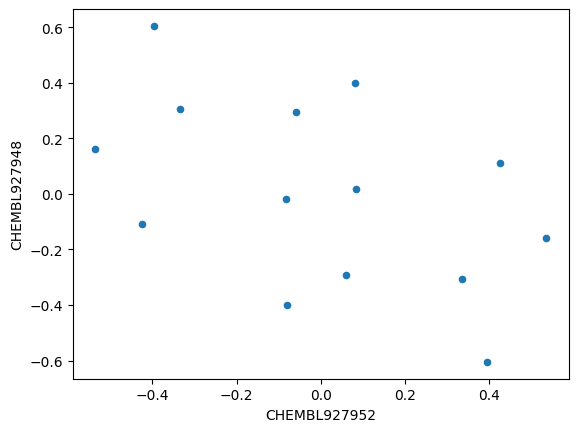

In [10]:
%matplotlib inline
df_plot.plot.scatter('CHEMBL927952', 'CHEMBL927948')